# Libraries

In [2]:
from tqdm import tqdm
import os
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tensorflow.keras import preprocessing 
import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Activation, Flatten, Dropout, BatchNormalization, LayerNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping
import imutils
import tensorflow as tf
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.applications.resnet50 import ResNet50 as ResNet50
from tensorflow.keras.applications.resnet50 import decode_predictions,preprocess_input

#init_notebook_mode(connected=True)
RANDOM_SEED = 123

# Get file name and their labels

Disease levels

0 - No DR
1 - Mild
2 - Moderate
3 - Severe
4 - Proliferative DR

In [3]:
# function to get all file names
def get_file_names_list(path,folder):
    for dirname, _, filenames in os.walk(path+'/'+str(folder) +'/'):
        files_names=[]
        for filename in filenames:
            files_names.append(filename)
           
    return  files_names

In [4]:
# getting all file names in train directory 
path=os.getcwd()
all_file_in_train_dir=get_file_names_list(path,'train')
all_file_in_train_dir=[s.replace('.jpeg', '') for s in all_file_in_train_dir]

In [5]:
# loading all labels (the dataset was bigger is the list contains a lot of labels. here we use a fraction of data)
labels=pd.read_csv('trainLabels.csv')
# getting the labels of the files we have for training
train_labels_indicies=[]
for var in all_file_in_train_dir:
    train_labels_indicies.append(labels['image'][labels['image'] == var ].index[0])
# new dataframe of labels
labels=labels.iloc[train_labels_indicies]    

Text(0.5, 0, 'Number of samples per class')

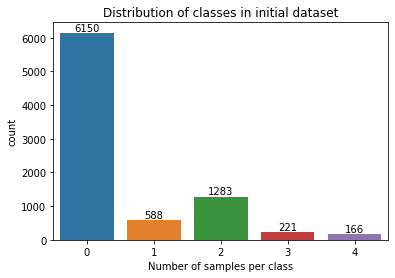

In [171]:
# get to see the disturbution of data
ax =sns.countplot(data=labels, x='level')
ncount=2
for  p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate(format(int(y)), (x.mean(), y), 
            ha='center', va='bottom')
plt.title('Distribution of classes in initial dataset')
plt.xlabel('Number of samples per class')

since the data is imbalanced, and we want to start out with an easy model, we merge all the unhealthy patients as one category

Text(0.5, 0, 'Number of samples per class')

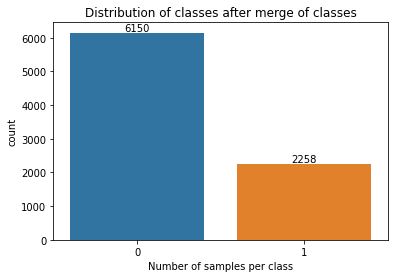

In [172]:
labels=labels.replace({'level': {2: 2, 2: 1, 3:1, 4:1}})
# get to see the disturbution of data after merge
ax =sns.countplot(data=labels, x='level')
ncount=2
for  p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate(format(int(y)), (x.mean(), y), 
            ha='center', va='bottom')
plt.title('Distribution of classes after merge of classes')
plt.xlabel('Number of samples per class')

The data is still imbalanced, we delete some patients from healthy class to have the same number of samples per class

Text(0.5, 0, 'Number of samples per class')

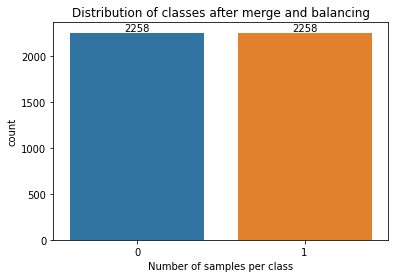

In [174]:
# number of samples in the smaller class
n=labels['level'][labels['level'] == 1 ].count()
# draw sample randomly
df_help=labels[labels['level'] == 0 ].sample(n=n,random_state=0)
# which samples to keep
rows_to_keep=list(df_help.index)+list(labels[labels['level'] == 1 ].index)

#reduce the sample size
labels=labels.loc[rows_to_keep]
ax =sns.countplot(data=labels, x='level')
ncount=2
for  p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate(format(int(y)), (x.mean(), y), 
            ha='center', va='bottom')
plt.title('Distribution of classes after merge and balancing')
plt.xlabel('Number of samples per class')

In [176]:
# save for later use for metrics
labels_train=labels

### splitting the data into train and test set

In [266]:
# test set (making sure there is a balanced amount of both classes)

# label 1
help_df_label_1=labels[labels['level'] ==1]
data_split_threshold=int(len(help_df_label_1)*0.3)
test_set_indecies_1=list(help_df_label_1.iloc[:data_split_threshold].index)

# label 0
help_df_label_0=labels[labels['level'] ==0]
data_split_threshold=int(len(help_df_label_0)*0.3)
test_set_indecies_0=list(help_df_label_0.iloc[:data_split_threshold].index)


Text(0.5, 0, 'Number of samples per class')

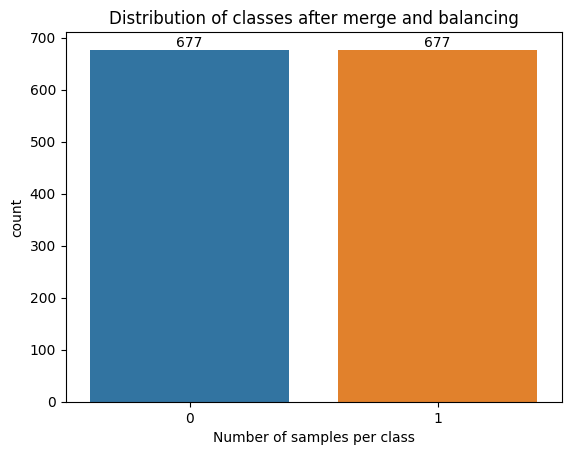

In [267]:
# save the test labels
test_set_indecies= [*test_set_indecies_0, *test_set_indecies_1]

labels_test=labels.loc[test_set_indecies]
#make sure the numbers/the sample size are correct 
ax =sns.countplot(data=labels_test, x='level')
ncount=2
for  p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate(format(int(y)), (x.mean(), y), 
            ha='center', va='bottom')
plt.title('Distribution of classes after merge and balancing')
plt.xlabel('Number of samples per class')

copying the files we want to use as train or test set to a new directory, also the images have to be sorted into seperate directories base on class

### **** SKIP AFTER FIRST RUN (DON NOT NEED TO RUN EACH TIME)***

In [13]:
# function to copy file from one directory to other
def copy_files_from_list_to_new_dir(path,folder_pre,folder_post,files_names_post_list):
    folder_post=path+'/'+ folder_post
    for dirname, _, filenames in os.walk(path+'/'+str(folder_pre) +'/'):
        files_names=[]
        for filename in filenames:
            filename_w_path=path+'/'+str(folder_pre) +'/'+filename
            if filename_w_path in files_names_post_list:
                file_post=folder_post+'/'+filename
                shutil.copyfile(filename_w_path,file_post)

### **** SKIP AFTER FIRST RUN (DON NOT NEED TO RUN EACH TIME)***

In [14]:
# spli the test set and copy to new directory  
files_names_post_test=[]
test_set_indecies= [*test_set_indecies_0, *test_set_indecies_1]
old_folder='train'

for image in labels.loc[test_set_indecies]['image']:
    files_names_post_test.append(path+'/'+ old_folder+ '/' +str(image) +'.jpeg')
copy_files_from_list_to_new_dir(path,'train','test_splitted/test',files_names_post_test)


Text(0.5, 0, 'Number of samples per class')

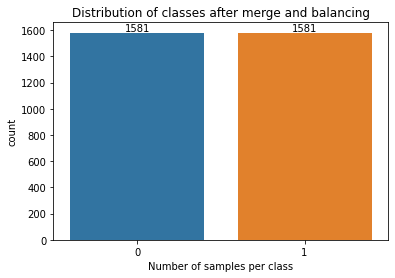

In [9]:
# now omit/drop the images that are in test set
labels.drop( test_set_indecies, axis=0, inplace=True)
#make sure the numbers/the sample size are correct 
ax =sns.countplot(data=labels, x='level')
ncount=2
for  p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate(format(int(y)), (x.mean(), y), 
            ha='center', va='bottom')
plt.title('Distribution of classes after merge and balancing')
plt.xlabel('Number of samples per class')

### **** SKIP AFTER FIRST RUN (DON NOT NEED TO RUN EACH TIME)***

In [16]:
# copy to new directory (train subset)
files_names_post=[]
old_folder='train'

# healthy Cohort
for image in labels[labels['level'] ==0]['image']:
    files_names_post.append(path+'/'+ old_folder+ '/' +str(image) +'.jpeg')
copy_files_from_list_to_new_dir(path,'train','train_balanced_0_1/Healthy',files_names_post)

# Not healthy Cohort
for image in labels[labels['level'] ==1]['image']:
    files_names_post.append(path+'/'+ old_folder+ '/' +str(image) +'.jpeg')
copy_files_from_list_to_new_dir(path,'train','train_balanced_0_1/NotHealthy',files_names_post)

____

# Load images

In [1]:
data_train_path=path+'/'+'train_balanced_0_1'
data_test_path=path+'/'+'test_splitted'
# example image
img = cv2.imread(data_train_path+'/Healthy/'+labels['image'].iloc[0]+'.jpeg')
print(type(img))
plt.axis("off")
#plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

NameError: name 'path' is not defined

In [7]:
classes = ['Healthy', 'Not Healthy']

____

Image preprocessing function 

In [105]:
# come back later the channel of image problem, for improvement
def crop_img(img,add_pixels_value=0,img_size=(224,224)):

    img_backup=img.copy()    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    cvuint8 = cv2.convertScaleAbs(img)
    
    gray = cv2.GaussianBlur(cvuint8, (5, 5), 0)
    
    # threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 20, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)
    
    # find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    
    # find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    ADD_PIXELS = add_pixels_value
    new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS]
    new_img_resized = cv2.resize(
            new_img,
            dsize=img_size,
            interpolation=cv2.INTER_CUBIC)
    new_img_rgb = cv2.cvtColor(new_img_resized,cv2.COLOR_GRAY2RGB)
    new_img_uit8 = cv2.convertScaleAbs(new_img_rgb)
    
    return new_img_uit8
    
im2=crop_img(img)
plt.axis("off")
plt.imshow(cv2.cvtColor(im2, cv2.COLOR_BGR2RGB))
#gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
im2.shape    

____

Data Generator

In [101]:
# to increase the amount of images
data_gen = preprocessing.image.ImageDataGenerator(
     preprocessing_function=preprocess_input,
     rotation_range=15,
     width_shift_range=0.05,
     height_shift_range=0.05,
     shear_range=0.05,
     horizontal_flip=True,
     vertical_flip=True,  
     rescale=1 / 255.0,
     fill_mode="nearest",
     validation_split=0.20
)
test_datagen = preprocessing.image.ImageDataGenerator(
     preprocessing_function=preprocess_input,
     rescale=1 / 255.0)
     
#for i in range(30):
#    image.next()     

In [127]:
batch_size = 50

train_generator = data_gen.flow_from_directory(
    directory=data_train_path,
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    subset='training',
    shuffle=True,
    seed=42
)
valid_generator = data_gen.flow_from_directory(
    directory=data_train_path,
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    subset='validation',
    shuffle=True,
    seed=42
)
test_generator =test_datagen.flow_from_directory(
    directory=data_test_path,
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=1,
    class_mode=None,
    shuffle=False,
    seed=42
)


Found 3795 images belonging to 2 classes.
Found 948 images belonging to 2 classes.
Found 1354 images belonging to 1 classes.


In [25]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [105]:
K.clear_session()

In [35]:
#xtrain, ytrain = next(train_generator)
#xtrain.shape, ytrain.shape


In [ ]:
inputs = tf.keras.Input(shape=(224, 224, 3))

In [114]:
base_model = ResNet50(
    weights='imagenet', 
    pooling='avg',      # applies global average pooling to the output of the last conv layer (like a flattening)
    include_top=False,  # !!!!! we only want to have the base, not the final dense layers 
    input_shape=(224, 224, 3),
    #inputs=inputs
    #input=keras(shape=(224, 224, 3))
)

In [108]:
model = Sequential()
model.add(base_model)

In [38]:
NUM_CLASSES = 2


model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(NUM_CLASSES, activation='softmax'))

#model.layers[0].trainable = False

model.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=1e-2, momentum=0.9),
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 2)                 4098      
                                                                 
Total params: 23,591,810
Trainable params: 23,538,690
Non-trainable params: 53,120
_________________________________________________________________


/Users/kashi/opt/anaconda3/envs/CNN_week/lib/python3.9/site-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [39]:
# model.add(BatchNormalization())
# model.add(Flatten())
# model.add(Dense(512,activation='relu'))    
# model.add(Dropout(rate=0.3))
# model.add(Dense(len(classes),activation= 'softmax'))

# # model summary 
# model.summary()

In [40]:
# model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])  

In [41]:
EPOCHS = 10
batch_size=30
es = EarlyStopping(
    monitor='val_loss', 
    mode='max',
    patience=6
)


history = model.fit_generator(
    train_generator,
    steps_per_epoch=None, # train_df.shape[0]
    epochs=EPOCHS,
    validation_data=valid_generator,
    validation_steps=None, #valid_df.shape[0]
    callbacks=[es]
)

/var/folders/fx/0vwqgk8x1js668174wzjjmb00000gr/T/ipykernel_17509/4197544647.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/10
76/76 [==============================] - 967s 13s/step - loss: 2.7927 - accuracy: 0.6448 - val_loss: 50694468.0000 - val_accuracy: 0.3333
Epoch 2/10
76/76 [==============================] - 972s 13s/step - loss: 1.9839 - accuracy: 0.6551 - val_loss: 55890.0234 - val_accuracy: 0.4673
Epoch 3/10
76/76 [==============================] - 1003s 13s/step - loss: 1.6239 - accuracy: 0.6298 - val_loss: 1634.1909 - val_accuracy: 0.6593
Epoch 4/10
76/76 [==============================] - 983s 13s/step - loss: 1.2333 - accuracy: 0.6013 - val_loss: 27.3314 - val_accuracy: 0.4241
Epoch 5/10
76/76 [==============================] - 5547s 74s/step - loss: 0.8559 - accuracy: 0.5968 - val_loss: 0.9026 - val_accuracy: 0.3344
Epoch 6/10
76/76 [==============================] - 39821s 516s/step - loss: 0.7291 - accuracy: 0.6158 - val_loss: 0.6417 - val_accuracy: 0.6667
Epoch 7/10
76/76 [==============================] - 1067s 14s/step - loss: 0.6542 - accuracy: 0.6590 - val_loss: 0.6996 - val_ac

In [ ]:
#callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
#model_training = model.fit(train_generator, epochs=100,validation_data=valid_generator , callbacks=[callback], verbose=1)

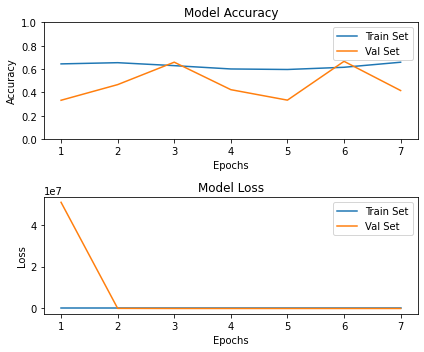

In [71]:
# plot model performance
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(6,5))

plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.ylim([0,1])


plt.subplot(2, 1, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
#plt.ylim([0,:])

plt.tight_layout()
plt.show()

save model

In [ ]:
history.model.save('v2_ResNet50.h5')

### metrics

first Train set

In [162]:
filenames = train_generator.filenames

In [ ]:
# get the file names that were used for traing and we will get the predictions for
filenames = train_generator.filenames
nb_samples = len(filenames) # this will be need for predictionfrom generator
filenames=[file.replace('NotHealthy/','') for file in filenames]
filenames=[file.replace('Healthy/','') for file in filenames]
filenames=[file.replace('.jpeg','') for file in filenames]
# save the names so wecan zip them with predictions and compare with true label later
train_prediction=pd.DataFrame({'image': filenames})

In [153]:
# validate on train set
predictions = history.model.predict_generator(train_generator, steps = nb_samples)
#convert probilities to labels threshold 0.5
predictions_label_train=[]
for i in range(len(predictions)):
    if (predictions[i][0]>=0.5):
        predictions_label_train.append(0)
    else:
        predictions_label_train.append(1)

train_prediction['prediction']=predictions_label_train
#lambda function not correct work on it
#predictions_label=[lambda x:1 if i>0.5 else 0 for x in predictions[i][0]]

/var/folders/fx/0vwqgk8x1js668174wzjjmb00000gr/T/ipykernel_17509/975720580.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = history.model.predict_generator(train_generator, steps = nb_samples)


In [166]:
# prepration for metrics 
train_prediction['prediction']=predictions_label_train
train_prediction.set_index('image', inplace=True)
labels_train.reset_index(inplace=True)
labels_train.drop('index',inplace=True, axis=1 )
labels_train.set_index('image', inplace=True)
train_prediction_actual = pd.merge(train_prediction, labels_train, on='image')
train_prediction_actual.rename(columns={'level': 'actual'}, inplace=True)

In [251]:
from sklearn.metrics import accuracy_score, confusion_matrix,plot_confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc,RocCurveDisplay, classification_report
accuracy = accuracy_score(train_prediction_actual['actual'], train_prediction_actual['prediction'])
print('Training set Accuracy = %.2f' % accuracy)

Training set Accuracy = 0.56


In [249]:
# figures style
plt.rcParams['font.size'] = 14
plt.rcParams['font.family'] = 'Calibri'
plt.rcParams['text.color'] = 'grey'
plt.rcParams['savefig.bbox'] = 'tight'

from cycler import cycler
navy = (56 / 256, 74 / 256, 143 / 256)
teal = (106 / 256, 197 / 256, 179 / 256)
pink = [199 / 255, 99 / 255, 150 / 255]
plt.rcParams['axes.prop_cycle'] = cycler(color=[teal, navy, pink])
import matplotlib as mpl
mpl.style.use('default')



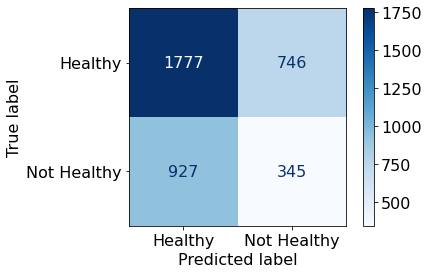

In [237]:
# train set
confusion_mtx = confusion_matrix(train_prediction_actual['actual'], train_prediction_actual['prediction']) 
cm = ConfusionMatrixDisplay(confusion_mtx, display_labels=classes)
cm.plot(cmap=plt.cm.Blues)

ROC

In [ ]:
RocCurveDisplay.from_predictions(train_prediction_actual['actual'], predictions[:,0])
# this should be replaced by predictions[:,0]

In [254]:
print(classification_report(train_prediction_actual['actual'], train_prediction_actual['prediction']))

              precision    recall  f1-score   support

           0       0.66      0.70      0.68      2523
           1       0.32      0.27      0.29      1272

    accuracy                           0.56      3795
   macro avg       0.49      0.49      0.49      3795
weighted avg       0.54      0.56      0.55      3795



Now for validation or test set

In [277]:
filenames = test_generator.filenames

In [278]:
# get the file names that were used for traing and we will get the predictions for
filenames = test_generator.filenames
nb_samples = len(filenames) # this will be need for predictionfrom generator
filenames=[file.replace('test/','') for file in filenames]
filenames=[file.replace('NotHealthy/','') for file in filenames]
filenames=[file.replace('Healthy/','') for file in filenames]
filenames=[file.replace('.jpeg','') for file in filenames]
# save the names so wecan zip them with predictions and compare with true label later
test_prediction=pd.DataFrame({'image': filenames})

In [ ]:
# validate on train set
predictions = history.model.predict_generator(test_generator, steps = nb_samples)
#convert probilities to labels threshold 0.5
predictions_label_test=[]
for i in range(len(predictions)):
    if (predictions[i][0]>=0.5):
        predictions_label_test.append(0)
    else:
        predictions_label_test.append(1)

#predictions_label_test['prediction']=predictions_label_test


In [ ]:
# prepration for metrics 
test_prediction['prediction']=predictions_label_test
test_prediction.set_index('image', inplace=True)
labels_test.reset_index(inplace=True)
labels_test.drop('index',inplace=True, axis=1 )
labels_test.set_index('image', inplace=True)
test_prediction_actual = pd.merge(test_prediction, labels_test, on='image')
test_prediction_actual.rename(columns={'level': 'actual'}, inplace=True)

In [283]:
from sklearn.metrics import accuracy_score, confusion_matrix,plot_confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc,RocCurveDisplay, classification_report
accuracy = accuracy_score(test_prediction_actual['actual'], test_prediction_actual['prediction'])
print('Training set Accuracy = %.2f' % accuracy)

Training set Accuracy = 0.49


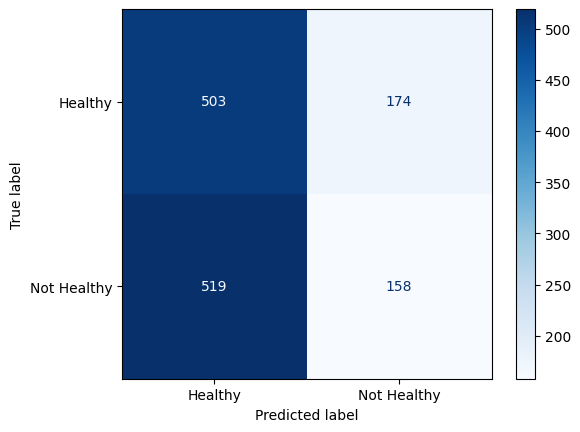

In [284]:
# train set
confusion_mtx = confusion_matrix(test_prediction_actual['actual'], test_prediction_actual['prediction']) 
cm = ConfusionMatrixDisplay(confusion_mtx, display_labels=classes)
cm.plot(cmap=plt.cm.Blues)

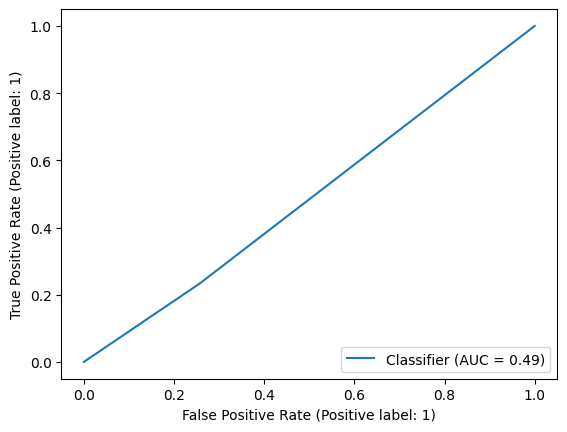

In [285]:
RocCurveDisplay.from_predictions(test_prediction_actual['actual'], test_prediction_actual['prediction'])

In [286]:
print(classification_report(test_prediction_actual['actual'], test_prediction_actual['prediction']))

              precision    recall  f1-score   support

           0       0.49      0.74      0.59       677
           1       0.48      0.23      0.31       677

    accuracy                           0.49      1354
   macro avg       0.48      0.49      0.45      1354
weighted avg       0.48      0.49      0.45      1354



____

In [ ]:
#CNN
model = Sequential()

#1st Module
model.add(Conv2D(32, (3, 3),  padding='same', activation='relu', input_shape=(256, 256, 3)))
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))
# model.add(BatchNormalization())

#2nd Module
model.add(Conv2D(64, (3, 3),  padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3),  padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3),  padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.2))
# model.add(BatchNormalization())

#3rd Module
model.add(Conv2D(128, (3, 3), (1,1), padding='same', activation='relu'))
model.add(Conv2D(128, (3, 3), (1,1), padding='same', activation='relu'))
model.add(Conv2D(128, (3, 3), (1,1), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

#4th Module
model.add(Conv2D(256, (3, 3), (1,1), padding='same', activation='relu'))
model.add(Conv2D(256, (3, 3), (1,1), padding='same', activation='relu'))
model.add(Conv2D(256, (3, 3), (1,1), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.2))

#4th Module
model.add(Conv2D(512, (3, 3), (1,1), padding='same', activation='relu'))
model.add(Conv2D(512, (3, 3), (1,1), padding='same', activation='relu'))
model.add(Conv2D(512, (3, 3), (1,1), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

#Flatten the layers
model.add(Flatten())

#Fully connected layers
model.add(Dense(1024, activation='relu'))
# model.add(Dropout(0.25))
model.add(Dense(5, activation='softmax'))
model.summary()

In [30]:
def prepare_model():
    model = Sequential()
    model.add(Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=(224, 224, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(16, activation='relu'))
    model.add(Dense(2, activation='sigmoid'))
    model.compile(loss="binary_crossentropy",optimizer="adam",metrics=['accuracy'])
    return model

In [31]:
model = prepare_model()
model.fit_generator(train_generator,
                    validation_data = train_generator,
                    steps_per_epoch = train_generator.n//train_generator.batch_size,
                    validation_steps = valid_generator.n//valid_generator.batch_size,
                    epochs=5)

2023-01-21 17:40:38.460519: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/var/folders/fx/0vwqgk8x1js668174wzjjmb00000gr/T/ipykernel_87493/2668527160.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_generator,


Epoch 1/5
223/474 [=============>................] - ETA: 3:23 - loss: 0.7098 - accuracy: 0.6609

2023-01-21 17:43:41.078347: W tensorflow/core/framework/op_kernel.cc:1733] UNKNOWN: OSError: image file is truncated (37 bytes not processed)
Traceback (most recent call last):

  File "/Users/kashi/opt/anaconda3/envs/CNN_week/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 271, in __call__
    ret = func(*args)

  File "/Users/kashi/opt/anaconda3/envs/CNN_week/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "/Users/kashi/opt/anaconda3/envs/CNN_week/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py", line 1004, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/Users/kashi/opt/anaconda3/envs/CNN_week/lib/python3.9/site-packages/keras/engine/data_adapter.py", line 830, in wrapped_generator
    for data in generator_fn():

  File "/Users/kashi/opt/anaconda3/envs/CNN_week/lib/python3.9/site-packages/keras/engine/data_adapte

UnknownError: Graph execution error:

OSError: image file is truncated (37 bytes not processed)
Traceback (most recent call last):

  File "/Users/kashi/opt/anaconda3/envs/CNN_week/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 271, in __call__
    ret = func(*args)

  File "/Users/kashi/opt/anaconda3/envs/CNN_week/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "/Users/kashi/opt/anaconda3/envs/CNN_week/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py", line 1004, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/Users/kashi/opt/anaconda3/envs/CNN_week/lib/python3.9/site-packages/keras/engine/data_adapter.py", line 830, in wrapped_generator
    for data in generator_fn():

  File "/Users/kashi/opt/anaconda3/envs/CNN_week/lib/python3.9/site-packages/keras/engine/data_adapter.py", line 956, in generator_fn
    yield x[i]

  File "/Users/kashi/opt/anaconda3/envs/CNN_week/lib/python3.9/site-packages/keras_preprocessing/image/iterator.py", line 65, in __getitem__
    return self._get_batches_of_transformed_samples(index_array)

  File "/Users/kashi/opt/anaconda3/envs/CNN_week/lib/python3.9/site-packages/keras_preprocessing/image/iterator.py", line 227, in _get_batches_of_transformed_samples
    img = load_img(filepaths[j],

  File "/Users/kashi/opt/anaconda3/envs/CNN_week/lib/python3.9/site-packages/keras_preprocessing/image/utils.py", line 138, in load_img
    img = img.resize(width_height_tuple, resample)

  File "/Users/kashi/opt/anaconda3/envs/CNN_week/lib/python3.9/site-packages/PIL/Image.py", line 1961, in resize
    self.load()

  File "/Users/kashi/opt/anaconda3/envs/CNN_week/lib/python3.9/site-packages/PIL/ImageFile.py", line 247, in load
    raise OSError(

OSError: image file is truncated (37 bytes not processed)


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]] [Op:__inference_train_function_765]

model.summary()

In [ ]:
model.history.keys()
pd.DataFrame(model.history)[['loss', 'val_loss']].plot()
plt.xlabel('epochs')
plt.ylabel('loss')

#
pd.DataFrame(model.history)[['val_accuracy', 'accuracy']].plot()
plt.xlabel('epochs')
plt.ylabel('accuracy')

___

## To export model as a coreml model

In [118]:
import coremltools
import tensorflow as tf

model_path = '/Users/You/YourModelPath.h5'

keras_model =  tf.keras.models.load_model('v2_ResNet50.h5')

classifier_config = coremltools.ClassifierConfig(classes)

#model = coremltools.convert(keras_model, convert_to="mlprogram", 
#     classifier_config = classifier_config,inputs=[ct.ImageType(shape=(1,3,224,224), color_layout=ct.colorlayout.RGB)] )
model = coremltools.convert(keras_model, convert_to="mlprogram", classifier_config = classifier_config,
    inputs=[ct.ImageType(shape=(1,224,224,3), color_layout=ct.colorlayout.RGB)] )


model.save("v2_ResNet5_2")

2023-01-23 17:35:30.203595: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2023-01-23 17:35:30.203669: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-01-23 17:35:30.214034: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:1164] Optimization results for grappler item: graph_to_optimize
  function_optimizer: function_optimizer did nothing. time = 0.003ms.
  function_optimizer: function_optimizer did nothing. time = 0.001ms.

2023-01-23 17:35:32.793134: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2023-01-23 17:35:32.793251: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-01-23 17:35:33.991310: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:116

____

In case resizing of image is neede for testing purpose on the phone

In [ ]:
img = cv2.imread(path+'/prelimanary_testig_from_train_set/'+'16_right.jpeg')
new_img_resized = cv2.resize(
            img,
            dsize=(224,224),
            interpolation=cv2.INTER_CUBIC)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
cv2.imwrite("prelimanary_testig_from_train_set/16_right_resized.jpeg", new_img_resized)